# Olist E‑Commerce Analytics — EDA

Exploratory analysis of orders, revenue, delivery performance, reviews, and categories using the Brazilian E‑Commerce Public Dataset by Olist.

In [1]:
# Imports & display settings
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)

## Paths & save helper (works locally & on Kaggle)

In [2]:
KAGGLE = os.path.exists('/kaggle/input')
WORK_DIR = '/kaggle/working' if KAGGLE else '.'
VIS_DIR = os.path.join(WORK_DIR, 'visuals')
os.makedirs(VIS_DIR, exist_ok=True)

def savefig_safe(name, dpi=300):
    path = os.path.join(VIS_DIR, name)
    plt.savefig(path, dpi=dpi, bbox_inches='tight')
    print(f"Saved figure → {path}")

# Data base path
DATA_BASE = '../data' if not KAGGLE else '/kaggle/input'

def find_kaggle_dir(candidates=(
    'olist-brazilian-ecommerce', 'brazilian-ecommerce', 'olist-ecommerce'
)):
    if not KAGGLE:
        return None
    try:
        entries = os.listdir('/kaggle/input')
    except Exception:
        return None
    for cand in candidates:
        for e in entries:
            if cand.lower() in e.lower():
                return os.path.join('/kaggle/input', e)
    return None

KAGGLE_DIR = find_kaggle_dir()
if KAGGLE and KAGGLE_DIR:
    DATA_BASE = KAGGLE_DIR
print('DATA_BASE =', DATA_BASE)

DATA_BASE = ../data


## Load CSVs

In [3]:
def p(*names):
    return os.path.join(DATA_BASE, *names)

orders   = pd.read_csv(p('olist_orders_dataset.csv'))
items    = pd.read_csv(p('olist_order_items_dataset.csv'))
payments = pd.read_csv(p('olist_order_payments_dataset.csv'))
reviews  = pd.read_csv(p('olist_order_reviews_dataset.csv'))
customers= pd.read_csv(p('olist_customers_dataset.csv'))
products = pd.read_csv(p('olist_products_dataset.csv'))
cats_tr  = pd.read_csv(p('product_category_name_translation.csv'))

print(orders.shape, items.shape, payments.shape, reviews.shape, customers.shape, products.shape, cats_tr.shape)
orders.head(2)

(99441, 8) (112650, 7) (103886, 5) (99224, 7) (99441, 5) (32951, 9) (71, 2)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00


## Dates & basic cleaning

In [4]:
# Convert timestamps to datetime
date_cols = [
    'order_purchase_timestamp','order_approved_at','order_delivered_carrier_date',
    'order_delivered_customer_date','order_estimated_delivery_date'
]
for c in date_cols:
    if c in orders.columns:
        orders[c] = pd.to_datetime(orders[c], errors='coerce')

if 'review_creation_date' in reviews.columns:
    reviews['review_creation_date'] = pd.to_datetime(reviews['review_creation_date'], errors='coerce')
if 'review_answer_timestamp' in reviews.columns:
    reviews['review_answer_timestamp'] = pd.to_datetime(reviews['review_answer_timestamp'], errors='coerce')

# Basic filters: delivered orders only for some analyses
delivered = orders[orders['order_status'].isin(['delivered'])].copy()
delivered.shape

(96478, 8)

## Build order‑level table (revenue, freight, customer, review)

In [5]:
# Item‑level revenue and freight summed to order level
item_agg = items.groupby('order_id', as_index=False).agg(
    revenue=('price', 'sum'),
    freight=('freight_value', 'sum'),
    n_items=('order_item_id','count')
)

# Payments: total paid per order
pay_agg = payments.groupby('order_id', as_index=False).agg(
    payment_total=('payment_value','sum')
)

# Reviews: latest review per order (if multiple)
rev_sorted = reviews.sort_values('review_creation_date')
rev_latest = rev_sorted.groupby('order_id', as_index=False).tail(1)[['order_id','review_score']]

# Customers: bring unique_id/state
cust_slim = customers[['customer_id','customer_unique_id','customer_state']].drop_duplicates('customer_id')

# Join all to an order‑level frame
ord_base = (delivered
    .merge(item_agg, on='order_id', how='left')
    .merge(pay_agg, on='order_id', how='left')
    .merge(rev_latest, on='order_id', how='left')
    .merge(cust_slim, on='customer_id', how='left')
)

# Derived metrics
ord_base['order_month'] = ord_base['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp()
ord_base['total_value'] = ord_base[['revenue','freight']].sum(axis=1)
ord_base.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,revenue,freight,n_items,payment_total,review_score,customer_unique_id,customer_state,order_month,total_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,29.99,8.72,1,38.71,4.0,7c396fd4830fd04220f754e42b4e5bff,SP,2017-10-01,38.71
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,118.70,22.76,1,141.46,4.0,af07308b275d755c9edb36a90c618231,BA,2018-07-01,141.46
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,159.90,19.22,1,179.12,5.0,3a653a41f6f9fc3d2a113cf8398680e8,GO,2018-08-01,179.12


## Monthly KPIs

In [6]:
kpi = ord_base.groupby('order_month', as_index=False).agg(
    orders=('order_id','nunique'),
    revenue=('total_value','sum'),
    customers=('customer_unique_id','nunique')
)
kpi['aov'] = kpi['revenue'] / kpi['orders']
kpi.head()

,order_month,orders,revenue,customers,aov
0,2016-09-01,1,143.46,1,143.460000
1,2016-10-01,265,46490.66,262,175.436453
2,2016-12-01,1,19.62,1,19.620000
3,2017-01-01,750,127482.37,718,169.976493
4,2017-02-01,1653,271239.32,1630,164.089123


### Plot: Orders & Revenue (monthly)

Saved figure → .\visuals\monthly_orders_revenue.png


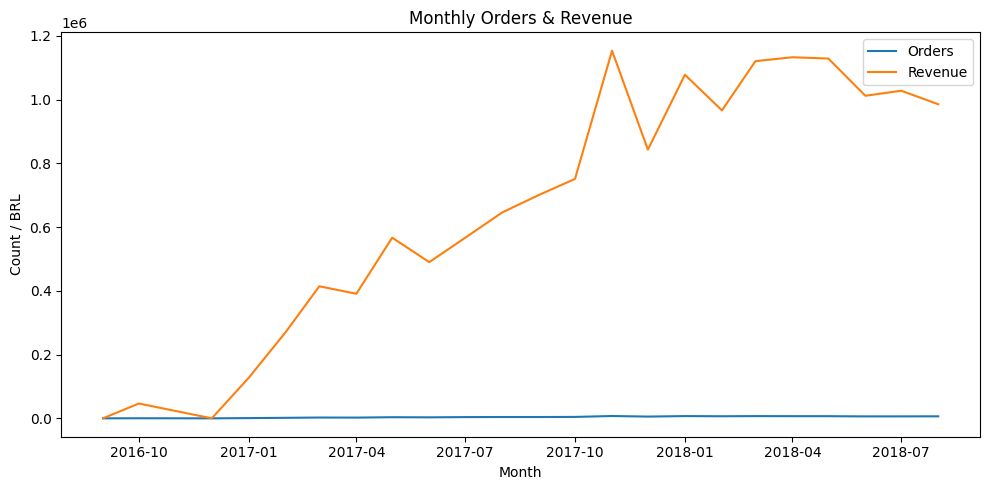

In [7]:
plt.figure(figsize=(10,5))
plt.plot(kpi['order_month'], kpi['orders'], label='Orders')
plt.plot(kpi['order_month'], kpi['revenue'], label='Revenue')
plt.title('Monthly Orders & Revenue')
plt.xlabel('Month'); plt.ylabel('Count / BRL')
plt.legend(); plt.tight_layout()
savefig_safe('monthly_orders_revenue.png')
plt.show()

### Plot: Average Order Value (AOV)

Saved figure → .\visuals\monthly_aov.png


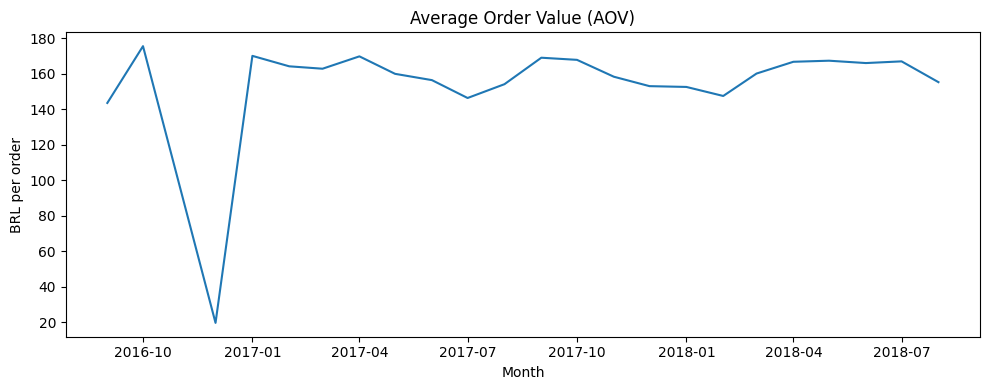

In [8]:
plt.figure(figsize=(10,4))
plt.plot(kpi['order_month'], kpi['aov'])
plt.title('Average Order Value (AOV)')
plt.xlabel('Month'); plt.ylabel('BRL per order')
plt.tight_layout()
savefig_safe('monthly_aov.png')
plt.show()

## Delivery performance (delivered vs estimated)

On‑time (<= 0 days): 93.2%  |  n=96470
Saved figure → .\visuals\delivery_delay_hist.png


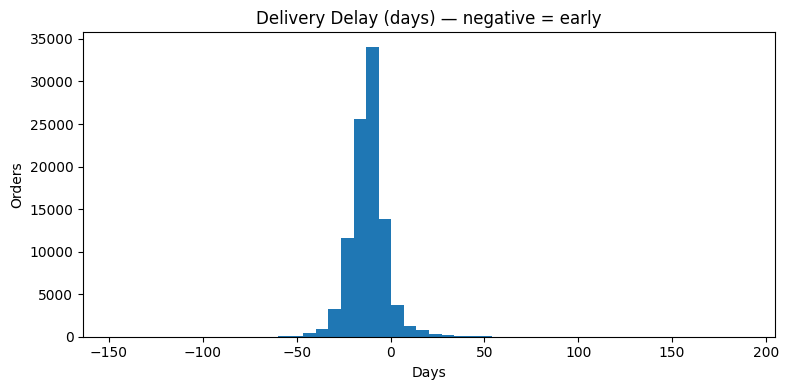

In [9]:
perf = ord_base[['order_id','order_delivered_customer_date','order_estimated_delivery_date']].dropna()
perf['delay_days'] = (perf['order_delivered_customer_date'] - perf['order_estimated_delivery_date']).dt.days
on_time_rate = (perf['delay_days'] <= 0).mean()
print(f'On‑time (<= 0 days): {on_time_rate:.1%}  |  n={len(perf)}')

plt.figure(figsize=(8,4))
plt.hist(perf['delay_days'], bins=50)
plt.title('Delivery Delay (days) — negative = early')
plt.xlabel('Days'); plt.ylabel('Orders')
plt.tight_layout()
savefig_safe('delivery_delay_hist.png')
plt.show()

## Reviews — score distribution

Saved figure → .\visuals\reviews_distribution.png


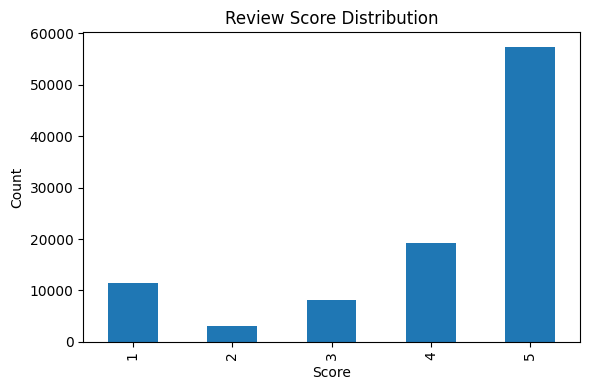

In [10]:
plt.figure(figsize=(6,4))
reviews['review_score'].value_counts().sort_index().plot(kind='bar')
plt.title('Review Score Distribution')
plt.xlabel('Score'); plt.ylabel('Count')
plt.tight_layout()
savefig_safe('reviews_distribution.png')
plt.show()

## Top categories by revenue (English names)

Saved figure → .\visuals\top_categories_revenue.png


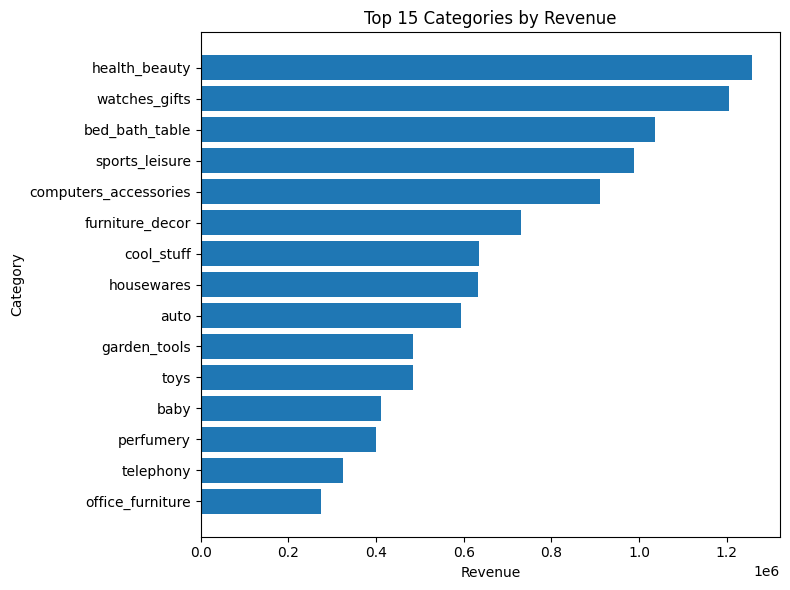

In [11]:
# Join items -> products -> English category names
prod = products.merge(cats_tr, on='product_category_name', how='left')
item_cat = items.merge(prod[['product_id','product_category_name_english']], on='product_id', how='left')
cat_rev = (item_cat.groupby('product_category_name_english', as_index=False)
                  .agg(revenue=('price','sum'))
                  .sort_values('revenue', ascending=False)
                  .head(15))

plt.figure(figsize=(8,6))
plt.barh(cat_rev['product_category_name_english'].iloc[::-1], cat_rev['revenue'].iloc[::-1])
plt.title('Top 15 Categories by Revenue')
plt.xlabel('Revenue'); plt.ylabel('Category')
plt.tight_layout()
savefig_safe('top_categories_revenue.png')
plt.show()

## (Optional) Customer retention cohorts

Saved figure → .\visuals\cohort_retention_heatmap.png


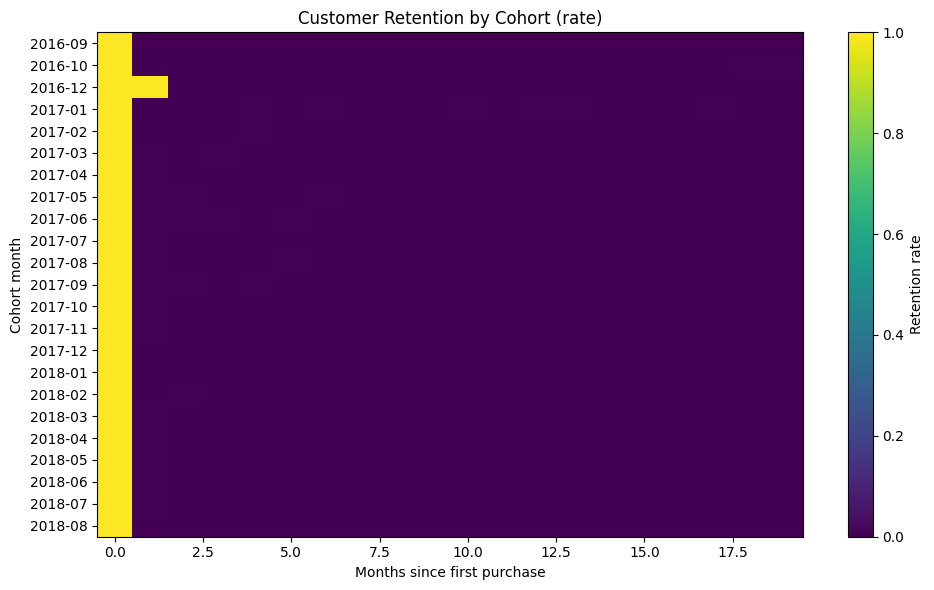

In [12]:
# Build a simple monthly retention cohort matrix
cust_orders = ord_base[['customer_unique_id','order_purchase_timestamp','order_id']].dropna().copy()
cust_orders['order_month'] = cust_orders['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp()

# First purchase month per customer
first_purchase = (cust_orders.groupby('customer_unique_id', as_index=False)['order_month']
                  .min().rename(columns={'order_month':'cohort_month'}))
cust_orders = cust_orders.merge(first_purchase, on='customer_unique_id', how='left')
cust_orders['period_number'] = ((cust_orders['order_month'].dt.year - cust_orders['cohort_month'].dt.year)*12 +
                                (cust_orders['order_month'].dt.month - cust_orders['cohort_month'].dt.month))

cohort_pivot = (cust_orders.groupby(['cohort_month','period_number'])['customer_unique_id']
                .nunique().reset_index().pivot(index='cohort_month', columns='period_number', values='customer_unique_id'))

# Convert to retention rate by dividing by period 0 (first month size)
cohort_sizes = cohort_pivot[0]
retention = cohort_pivot.divide(cohort_sizes, axis=0)

plt.figure(figsize=(10,6))
plt.imshow(retention.fillna(0).values, aspect='auto')
plt.title('Customer Retention by Cohort (rate)')
plt.xlabel('Months since first purchase'); plt.ylabel('Cohort month')
plt.colorbar(label='Retention rate')
plt.yticks(ticks=range(len(retention.index)), labels=[d.strftime('%Y-%m') for d in retention.index])
plt.tight_layout()
savefig_safe('cohort_retention_heatmap.png')
plt.show()

## Next steps
- Add drill‑downs (state, seller, payment types).
- Prepare a short insights summary for README.
- (Optional) Build a small dashboard with Plotly or Streamlit.